In [1]:
!pip install numpyro

     |████████████████████████████████| 250 kB 6.3 MB/s 


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive

## Problem 1

The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

In [3]:
pred_df = pd.DataFrame({'weight': [45, 40, 65, 31]})
pred_df['Intercept'] = 1.0
pred_df['log_weight'] = jnp.log(jnp.array(pred_df['weight']))

In [4]:
Howell1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Statistical Rethinking/data/Howell1.csv", sep=";")
Howell1['Intercept'] = 1.0
Howell1['log_weight'] = jnp.log(jnp.array(Howell1['weight']))
Howell1['log_height'] = jnp.log(jnp.array(Howell1['height']))
height_df = Howell1[Howell1['age'] >= 18]
height_df.head()

,height,weight,age,male,Intercept,log_weight,log_height
0,151.765,47.825606,63.0,1,1.0,3.867561,5.022333
1,139.700,36.485807,63.0,0,1.0,3.596923,4.939497
2,136.525,31.864838,65.0,0,1.0,3.461503,4.916508
3,156.845,53.041915,41.0,1,1.0,3.971082,5.055258
4,145.415,41.276872,51.0,0,1.0,3.720302,4.979592


In [5]:
def m_1(X, y=None):
  B = numpyro.sample('B', dist.Normal(0, 5), sample_shape=(X.shape[1],))
  sigma = numpyro.sample('sigma', dist.HalfNormal(1))
  mu = numpyro.deterministic('mu', X.dot(B))

  numpyro.sample('y', dist.Normal(mu, sigma), obs = y)

In [6]:
X = jnp.array(height_df[['Intercept', 'log_weight']])
y = jnp.array(height_df['log_height'])

In [7]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(m_1)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=4)
mcmc.run(rng_key_, X = X, y = y)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2374.70it/s, 127 steps of size 2.65e-02. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      B[0]      4.06      0.05      4.06      3.98      4.13   2264.49      1.00
      B[1]      0.26      0.01      0.26      0.24      0.28   2266.61      1.00
     sigma      0.03      0.00      0.03      0.03      0.04   2769.79      1.00

Number of divergences: 0


In [8]:
X_pred = jnp.array(pred_df[['Intercept','log_weight']])
predictive_1 = Predictive(m_1, samples_1)
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(m_1, samples_1)
predictions = predictive(rng_key_, X=X_pred)['y']

In [9]:
pred_df['expected_height'] = pd.Series(jnp.exp(jnp.mean(predictions, axis=0)))
quantiles = jnp.quantile(jnp.exp(predictions), axis=0, q=jnp.array([0.055, 0.945]))
pred_df['lower_89'] = pd.Series(quantiles[0,:])
pred_df['upper_89'] = pd.Series(quantiles[1,:])

In [10]:
pred_df

,weight,Intercept,log_weight,expected_height,lower_89,upper_89
0,45,1.0,3.806663,154.868927,146.820267,163.471512
1,40,1.0,3.688879,150.209869,142.372910,158.519699
2,65,1.0,4.174387,170.416031,161.664429,179.725876
3,31,1.0,3.433987,140.509201,133.135147,148.206909


## Problem 2
Model the relationship between height (cm) and the natural logarithm of weight (log-kg): log(weight). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Use any model type from Chapter 4 that you think useful: an ordinary linear regression, a polynomial or a spline. I recommend a plain linear regression, though. Plot the posterior predictions against the raw data.

In [11]:
X = jnp.array(Howell1[['Intercept','log_weight']])
y = jnp.array(Howell1['height'])

rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(m_1)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_chains=4, num_samples=num_samples)
mcmc.run(rng_key_, X = X, y = y)
mcmc.print_summary()
samples_2 = mcmc.get_samples()

/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 3875.96it/s, 31 steps of size 1.15e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      B[0]    -21.46      1.25    -21.45    -23.55    -19.46   2759.81      1.00
      B[1]     46.41      0.36     46.41     45.84     47.02   2773.74      1.00
     sigma      5.06      0.15      5.05      4.82      5.30   3385.30      1.00

Number of divergences: 0


In [12]:
X_pred = jnp.array([jnp.repeat(1, 50), jnp.log(jnp.linspace(start=1, stop=65))]).transpose()
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(m_1, samples_2)
predictions = predictive(rng_key_, X=X_pred)['y']

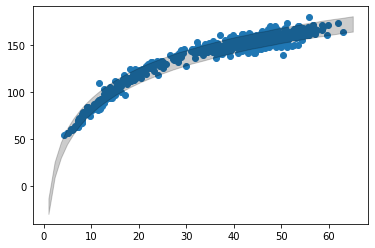

In [13]:
quantiles = jnp.quantile(predictions, axis=0, q=jnp.array([0.055, 0.945]))

plt.scatter(Howell1['weight'], Howell1['height'])
plt.fill_between(jnp.exp(X_pred[:,1]), quantiles[0,:],quantiles[1,:], color="k", alpha=0.2)
plt.show()

## Problem 3
Plot the prior predictive distribution for the polynomial regression model in Chapter 4. You can modify the the code that plots the linear regression prior predictive distribution. 20 or 30 parabolas from the prior should suffice to show where the prior probability resides. Can you modify the prior distributions of alpha, beta_1, and beta_2 so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to keep the curves consistent with what you know about height and weight, before seeing these exact data.

In [14]:
pred_df = pd.DataFrame({'weight': pd.Series(jnp.linspace(0, 65))})
pred_df['weight_s'] = (pred_df['weight'] - pred_df['weight'].mean())/pred_df['weight'].std()
pred_df['weight_s_sq'] = pred_df['weight_s'] * pred_df['weight_s']
X_pred = jnp.array(pred_df[['weight_s', 'weight_s_sq']])

In [15]:
def m_2(X, tau=50, B1_mu=0, B1_sd=10, B2_mu=0, B2_sd=10, c_mu = 178, c_sd = 100, y=None):
  sigma = numpyro.sample('sigma', dist.Uniform(0, tau))
  B1 = numpyro.sample('B1', dist.Normal(B1_mu, B1_sd))
  B2 = numpyro.sample('B2', dist.Normal(B2_mu, B2_sd))
  c = numpyro.sample('c', dist.Normal(c_mu, c_sd))
  mu = numpyro.deterministic('mu', c + X[:,0] * B1 + X[:,1] * B2)

  y = numpyro.sample('y', dist.Normal(mu, sigma), obs = y)

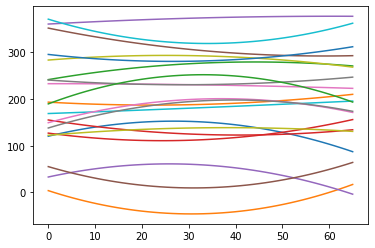

In [16]:
# Default configuration
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(m_2, num_samples=20)
prior_predictions = prior_predictive(rng_key_, X=X_pred)['mu']
for i in jnp.arange(20):
  plt.plot(pred_df['weight'],prior_predictions[i,:])

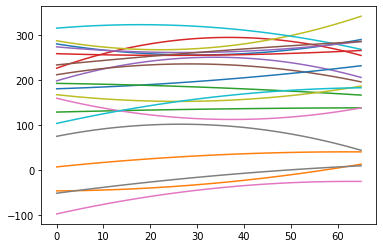

In [17]:
# sigma ~ Unif(0, 5)
# Should have no effect
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(m_2, num_samples=20)
prior_predictions = prior_predictive(rng_key_, X=X_pred, tau=5)['mu']
for i in jnp.arange(20):
  plt.plot(pred_df['weight'],prior_predictions[i,:])

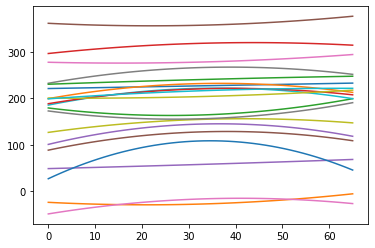

In [18]:
# sigma ~ Unif(0, 5)
# B1 ~ N(5, 1)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(m_2, num_samples=20)
prior_predictions = prior_predictive(rng_key_, X=X_pred, tau=5, B1_mu=5, B1_sd=1)['mu']
for i in jnp.arange(20):
  plt.plot(pred_df['weight'],prior_predictions[i,:])

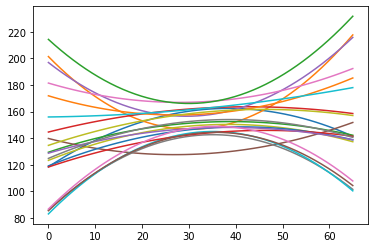

In [19]:
# sigma ~ Unif(0, 5)
# B1 ~ N(5, 1)
# c ~ N(150, 10)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(m_2, num_samples=20)
prior_predictions = prior_predictive(rng_key_, X=X_pred, tau=5, B1_mu=5, B1_sd=1, c_mu = 150, c_sd = 10)['mu']
for i in jnp.arange(20):
  plt.plot(pred_df['weight'],prior_predictions[i,:])

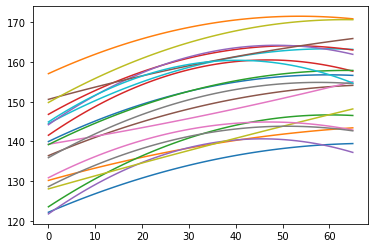

In [20]:
# sigma ~ Unif(0, 5)
# B1 ~ N(5, 1)
# c ~ N(150, 10)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(m_2, num_samples=20)
prior_predictions = prior_predictive(rng_key_, X=X_pred, tau=5, B1_mu=5, B1_sd=1,
                                     B2_mu = -2, B2_sd = 1, c_mu = 150, c_sd = 10)['mu']
for i in jnp.arange(20):
  plt.plot(pred_df['weight'],prior_predictions[i,:])

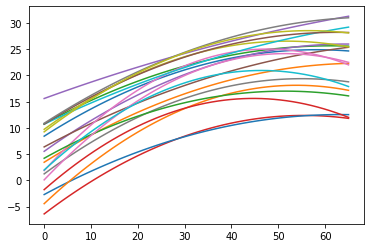

In [21]:
# sigma ~ Unif(0, 5)
# B1 ~ N(5, 1)
# B2 ~ N(-2, 1)
# c ~ N(20, 5)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(m_2, num_samples=20)
prior_predictions = prior_predictive(rng_key_, X=X_pred, tau=5, B1_mu=5, B1_sd=1,
                                     B2_mu = -2, B2_sd = 1, c_mu = 20, c_sd = 5)['mu']
for i in jnp.arange(20):
  plt.plot(pred_df['weight'],prior_predictions[i,:])

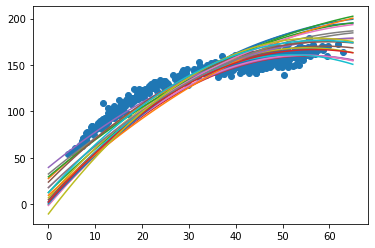

In [22]:
# sigma ~ Unif(0, 5)
# B1 ~ N(50, 5)
# B2 ~ N(-15, 5)
# c ~ N(140, 5)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(m_2, num_samples=20)
prior_predictions = prior_predictive(rng_key_, X=X_pred, tau=5, B1_mu=50, B1_sd=5,
                                     B2_mu = -15, B2_sd = 5, c_mu = 140, c_sd = 5)['mu']
plt.scatter(Howell1['weight'], Howell1['height'])
for i in jnp.arange(20):
  plt.plot(pred_df['weight'],prior_predictions[i,:])

# Not bad!